# NLP - Topic modelling  [TF-IDF + KNN]

In [1]:
import re


import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

In [2]:
# Constants - Configuration

LANGUAGE = "english"
from nltk.stem.snowball import EnglishStemmer as Stemmer

ALPHABET = "a-z0-9 "  # Lowercase letters, numbers and space.
ADDITIONAL_STOPWORDS = [] # Stopwords to add.
DATA_CACHE = ".cache"
RND_SEED = 42

In [3]:
# Data for NLTK
nltk.data.path.append(DATA_CACHE)


nltk.download(
    info_or_id='punkt',
    download_dir=DATA_CACHE
)


nltk.download(
    info_or_id='stopwords',
    download_dir=DATA_CACHE
)

[nltk_data] Downloading package punkt to .cache...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to .cache...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dataset

In [4]:
# Dataset
from sklearn.datasets import fetch_20newsgroups

In [5]:
newsgroups = fetch_20newsgroups(
    data_home=DATA_CACHE,
    subset="all",
    categories=None,
    shuffle=True,
    random_state=42,
    download_if_missing=True
)

### Inspect the dataset

In [6]:
print("Key - Number of elements:")
for k, v in newsgroups.items():
    print("- {}, {} elements".format(k, len(v)))

Key - Number of elements:
- data, 18846 elements
- filenames, 18846 elements
- target_names, 20 elements
- target, 18846 elements
- DESCR, 9443 elements


It seems to be a description field!

In [7]:
print(newsgroups['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [8]:
def print_new(document_id):
    print("""
    Example:
        - Document ID: {}
        - Category {} ({})
        - Text:
    {}
    """.format(
        document_id,
        newsgroups['target'][document_id],
        newsgroups['target_names'][ newsgroups['target'][document_id] ],
        newsgroups['data'][document_id]
    ))

In [9]:
print_new(10)


    Example:
        - Document ID: 10
        - Category 19 (talk.religion.misc)
        - Text:
    From: sandvik@newton.apple.com (Kent Sandvik)
Subject: Re: 14 Apr 93   God's Promise in 1 John 1: 7
Organization: Cookamunga Tourist Bureau
Lines: 17

In article <1qknu0INNbhv@shelley.u.washington.edu>, > Christian:  washed in
the blood of the lamb.
> Mithraist:  washed in the blood of the bull.
> 
> If anyone in .netland is in the process of devising a new religion,
> do not use the lamb or the bull, because they have already been
> reserved.  Please choose another animal, preferably one not
> on the Endangered Species List.  

This will be a hard task, because most cultures used most animals
for blood sacrifices. It has to be something related to our current
post-modernism state. Hmm, what about used computers?

Cheers,
Kent
---
sandvik@newton.apple.com. ALink: KSAND -- Private activities on the net.

    


In [10]:
print_new(50)


    Example:
        - Document ID: 50
        - Category 12 (sci.electronics)
        - Text:
    From: dino@inqmind.bison.mb.ca (Tony stewart)
Subject: Re: Making up odd resistor values required by filters
Organization: The Inquiring Mind BBS  1 204 488-1607
Lines: 29

idh@nessie.mcc.ac.uk (Ian Hawkins) writes:

> When constructing active filters,  odd values of resistor are often required 
> (i.e. something like a 3.14 K Ohm resistor).(It seems best to choose common 
> capacitor values and cope with the strange resistances then demanded).
> 
> Is there a PD program out there that will work out how best to make up such
> a resistance, given fixed resistors of the standard 12 values per decade?.(1,
> 1.2,1.5,1.8,2.2,3.3 etc ).  It is a common enough problem,  yet I cant 
> recall seing a program that tells that Rx+Ry//Rz gives Rq,  starting with 
> q and finding prefered values x,y and z.
> 
> 
> 			Cheers
> 				Ian H  
> 

WHen trying to choose a resistor with a tolerance better tha

### Processing.
We will modify the documents to feed the algorithm.

In this step we can take advantage of what we know about the documents  (**domain knowledge**) to clean them and present the classificator the best information available.

#### Filter headers
It is possible to see there are "headers" in the documents. The part correlated to the category should be what is written, and that happens from the first `writes:\n` appearance.

In [11]:
def filter_headers(text):
    return ''.join(text.split("writes:")[1:])

Original document.

In [12]:
print(newsgroups['data'][50])

From: dino@inqmind.bison.mb.ca (Tony stewart)
Subject: Re: Making up odd resistor values required by filters
Organization: The Inquiring Mind BBS  1 204 488-1607
Lines: 29

idh@nessie.mcc.ac.uk (Ian Hawkins) writes:

> When constructing active filters,  odd values of resistor are often required 
> (i.e. something like a 3.14 K Ohm resistor).(It seems best to choose common 
> capacitor values and cope with the strange resistances then demanded).
> 
> Is there a PD program out there that will work out how best to make up such
> a resistance, given fixed resistors of the standard 12 values per decade?.(1,
> 1.2,1.5,1.8,2.2,3.3 etc ).  It is a common enough problem,  yet I cant 
> recall seing a program that tells that Rx+Ry//Rz gives Rq,  starting with 
> q and finding prefered values x,y and z.
> 
> 
> 			Cheers
> 				Ian H  
> 

WHen trying to choose a resistor with a tolerance better than 1%, you 
need a trimmer or to screen devices, it can't be made from adding 2 
resitors of 1% value

Modified document.

In [13]:
print(
    filter_headers(newsgroups['data'][50])
)



> When constructing active filters,  odd values of resistor are often required 
> (i.e. something like a 3.14 K Ohm resistor).(It seems best to choose common 
> capacitor values and cope with the strange resistances then demanded).
> 
> Is there a PD program out there that will work out how best to make up such
> a resistance, given fixed resistors of the standard 12 values per decade?.(1,
> 1.2,1.5,1.8,2.2,3.3 etc ).  It is a common enough problem,  yet I cant 
> recall seing a program that tells that Rx+Ry//Rz gives Rq,  starting with 
> q and finding prefered values x,y and z.
> 
> 
> 			Cheers
> 				Ian H  
> 

WHen trying to choose a resistor with a tolerance better than 1%, you 
need a trimmer or to screen devices, it can't be made from adding 2 
resitors of 1% value in parallel, since the smaller device will have the 
error of 1% to cope with. 
You have 3 choices;
a) live with the error of 1% tolerance devices for low Q circuits or low 
sensitivity designs
b) buy resistors wit

#### Filter emails
This could cause spureous correlations. A person is should not be identified with a particular topic.


In [14]:
def get_filter_emails():
    pattern = re.compile('\S*@\S*\s?', re.UNICODE)
    def filter_emails(text):
        return pattern.sub('',text)
    return filter_emails

filter_emails = get_filter_emails()


In [15]:
print(
    filter_emails(newsgroups['data'][50])
)

From: (Tony stewart)
Subject: Re: Making up odd resistor values required by filters
Organization: The Inquiring Mind BBS  1 204 488-1607
Lines: 29

(Ian Hawkins) writes:

> When constructing active filters,  odd values of resistor are often required 
> (i.e. something like a 3.14 K Ohm resistor).(It seems best to choose common 
> capacitor values and cope with the strange resistances then demanded).
> 
> Is there a PD program out there that will work out how best to make up such
> a resistance, given fixed resistors of the standard 12 values per decade?.(1,
> 1.2,1.5,1.8,2.2,3.3 etc ).  It is a common enough problem,  yet I cant 
> recall seing a program that tells that Rx+Ry//Rz gives Rq,  starting with 
> q and finding prefered values x,y and z.
> 
> 
> 			Cheers
> 				Ian H  
> 

WHen trying to choose a resistor with a tolerance better than 1%, you 
need a trimmer or to screen devices, it can't be made from adding 2 
resitors of 1% value in parallel, since the smaller device will ha

#### Pipeline

In [16]:
documents = [
    filter_emails(filter_headers(document))
    for document
    in newsgroups['data']
]

In [17]:
categories = newsgroups['target']

In [18]:
print(documents[50])



> When constructing active filters,  odd values of resistor are often required 
> (i.e. something like a 3.14 K Ohm resistor).(It seems best to choose common 
> capacitor values and cope with the strange resistances then demanded).
> 
> Is there a PD program out there that will work out how best to make up such
> a resistance, given fixed resistors of the standard 12 values per decade?.(1,
> 1.2,1.5,1.8,2.2,3.3 etc ).  It is a common enough problem,  yet I cant 
> recall seing a program that tells that Rx+Ry//Rz gives Rq,  starting with 
> q and finding prefered values x,y and z.
> 
> 
> 			Cheers
> 				Ian H  
> 

WHen trying to choose a resistor with a tolerance better than 1%, you 
need a trimmer or to screen devices, it can't be made from adding 2 
resitors of 1% value in parallel, since the smaller device will have the 
error of 1% to cope with. 
You have 3 choices;
a) live with the error of 1% tolerance devices for low Q circuits or low 
sensitivity designs
b) buy resistors wit

In [19]:
print(newsgroups['target_names'][categories[50]])

sci.electronics


## Pre-processing documents (common steps)

## Alphabet
We are going to work with letters and spaces, no other symbols.

In [20]:
def get_filter_symbols():
    pattern = re.compile('[^{}]'.format(ALPHABET), re.UNICODE)
    def filter_symbols(text):
        return pattern.sub(' ', text.lower().replace('\s',' '))
    return filter_symbols

filter_symbols = get_filter_symbols()

In [21]:
documents[50]

"\n\n> When constructing active filters,  odd values of resistor are often required \n> (i.e. something like a 3.14 K Ohm resistor).(It seems best to choose common \n> capacitor values and cope with the strange resistances then demanded).\n> \n> Is there a PD program out there that will work out how best to make up such\n> a resistance, given fixed resistors of the standard 12 values per decade?.(1,\n> 1.2,1.5,1.8,2.2,3.3 etc ).  It is a common enough problem,  yet I cant \n> recall seing a program that tells that Rx+Ry//Rz gives Rq,  starting with \n> q and finding prefered values x,y and z.\n> \n> \n> \t\t\tCheers\n> \t\t\t\tIan H  \n> \n\nWHen trying to choose a resistor with a tolerance better than 1%, you \nneed a trimmer or to screen devices, it can't be made from adding 2 \nresitors of 1% value in parallel, since the smaller device will have the \nerror of 1% to cope with. \nYou have 3 choices;\na) live with the error of 1% tolerance devices for low Q circuits or low \nsensitivi

In [22]:
doc_alphabet = filter_symbols(documents[50])

print(doc_alphabet)

    when constructing active filters   odd values of resistor are often required     i e  something like a 3 14 k ohm resistor   it seems best to choose common    capacitor values and cope with the strange resistances then demanded        is there a pd program out there that will work out how best to make up such   a resistance  given fixed resistors of the standard 12 values per decade   1    1 2 1 5 1 8 2 2 3 3 etc     it is a common enough problem   yet i cant    recall seing a program that tells that rx ry  rz gives rq   starting with    q and finding prefered values x y and z             cheers       ian h       when trying to choose a resistor with a tolerance better than 1   you  need a trimmer or to screen devices  it can t be made from adding 2  resitors of 1  value in parallel  since the smaller device will have the  error of 1  to cope with   you have 3 choices  a  live with the error of 1  tolerance devices for low q circuits or low  sensitivity designs b  buy resistors wit

### Tokenization

In [23]:
doc_tokens = word_tokenize(
    text=filter_symbols(documents[50]),
    language=LANGUAGE
)

print(doc_tokens)
print("\nTokens: {}".format(len(doc_tokens)) )

['when', 'constructing', 'active', 'filters', 'odd', 'values', 'of', 'resistor', 'are', 'often', 'required', 'i', 'e', 'something', 'like', 'a', '3', '14', 'k', 'ohm', 'resistor', 'it', 'seems', 'best', 'to', 'choose', 'common', 'capacitor', 'values', 'and', 'cope', 'with', 'the', 'strange', 'resistances', 'then', 'demanded', 'is', 'there', 'a', 'pd', 'program', 'out', 'there', 'that', 'will', 'work', 'out', 'how', 'best', 'to', 'make', 'up', 'such', 'a', 'resistance', 'given', 'fixed', 'resistors', 'of', 'the', 'standard', '12', 'values', 'per', 'decade', '1', '1', '2', '1', '5', '1', '8', '2', '2', '3', '3', 'etc', 'it', 'is', 'a', 'common', 'enough', 'problem', 'yet', 'i', 'cant', 'recall', 'seing', 'a', 'program', 'that', 'tells', 'that', 'rx', 'ry', 'rz', 'gives', 'rq', 'starting', 'with', 'q', 'and', 'finding', 'prefered', 'values', 'x', 'y', 'and', 'z', 'cheers', 'ian', 'h', 'when', 'trying', 'to', 'choose', 'a', 'resistor', 'with', 'a', 'tolerance', 'better', 'than', '1', 'you'

### Stop Words

In [24]:
def get_filter_stopwords():
    stop_words = stopwords.words(LANGUAGE)
    stop_words.extend(ADDITIONAL_STOPWORDS)
    stop_words= set(stop_words)
    def filter_stopwords(tokens):
        return [word for word in tokens if word not in stop_words]
    return filter_stopwords

filter_stopwords = get_filter_stopwords()

In [25]:
doc_filtered_tokens = filter_stopwords(doc_tokens)

print(doc_filtered_tokens)
print("\nTokens: {}".format(len(doc_filtered_tokens)) )

['constructing', 'active', 'filters', 'odd', 'values', 'resistor', 'often', 'required', 'e', 'something', 'like', '3', '14', 'k', 'ohm', 'resistor', 'seems', 'best', 'choose', 'common', 'capacitor', 'values', 'cope', 'strange', 'resistances', 'demanded', 'pd', 'program', 'work', 'best', 'make', 'resistance', 'given', 'fixed', 'resistors', 'standard', '12', 'values', 'per', 'decade', '1', '1', '2', '1', '5', '1', '8', '2', '2', '3', '3', 'etc', 'common', 'enough', 'problem', 'yet', 'cant', 'recall', 'seing', 'program', 'tells', 'rx', 'ry', 'rz', 'gives', 'rq', 'starting', 'q', 'finding', 'prefered', 'values', 'x', 'z', 'cheers', 'ian', 'h', 'trying', 'choose', 'resistor', 'tolerance', 'better', '1', 'need', 'trimmer', 'screen', 'devices', 'made', 'adding', '2', 'resitors', '1', 'value', 'parallel', 'since', 'smaller', 'device', 'error', '1', 'cope', '3', 'choices', 'live', 'error', '1', 'tolerance', 'devices', 'low', 'q', 'circuits', 'low', 'sensitivity', 'designs', 'b', 'buy', 'resisto

### Stemming
This helps to reduce the number of terms in the vocabulary.

In [26]:
stemmer = Stemmer(ignore_stopwords=True)
stem = stemmer.stem

In [27]:
doc_stemmed = [stem(word) for word in doc_filtered_tokens]
print(doc_stemmed)

['construct', 'activ', 'filter', 'odd', 'valu', 'resistor', 'often', 'requir', 'e', 'someth', 'like', '3', '14', 'k', 'ohm', 'resistor', 'seem', 'best', 'choos', 'common', 'capacitor', 'valu', 'cope', 'strang', 'resist', 'demand', 'pd', 'program', 'work', 'best', 'make', 'resist', 'given', 'fix', 'resistor', 'standard', '12', 'valu', 'per', 'decad', '1', '1', '2', '1', '5', '1', '8', '2', '2', '3', '3', 'etc', 'common', 'enough', 'problem', 'yet', 'cant', 'recal', 'se', 'program', 'tell', 'rx', 'ry', 'rz', 'give', 'rq', 'start', 'q', 'find', 'prefer', 'valu', 'x', 'z', 'cheer', 'ian', 'h', 'tri', 'choos', 'resistor', 'toler', 'better', '1', 'need', 'trimmer', 'screen', 'devic', 'made', 'ad', '2', 'resitor', '1', 'valu', 'parallel', 'sinc', 'smaller', 'devic', 'error', '1', 'cope', '3', 'choic', 'live', 'error', '1', 'toler', 'devic', 'low', 'q', 'circuit', 'low', 'sensit', 'design', 'b', 'buy', 'resistor', 'better', '1', 'toler', 'vishay', 'dale', 'c', 'use', 'trimmer', 'sot', 'select'

### Pipeline

_NOTE: the speed can be improved._

In [28]:
# Destination variables
tokens = []
labels = []

for doc,cat in zip(documents, categories):
    doc_tokens = [
        stem(token)
        for token
        in filter_stopwords(word_tokenize(filter_symbols(doc)))
    ]
    if doc_tokens != []:
        tokens.append(doc_tokens)
        labels.append(cat)

assert(len(tokens)== len(labels))

## Classifier

### Train test split

In [29]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(
    tokens, labels,
    test_size=0.2,
    random_state=RND_SEED,
    shuffle=True,
    stratify=None
)

### Document vectorization

We are going to convert the token represenation of a document to a TF-IDF vector.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    tokenizer=lambda x: x,
    lowercase=False, # Internally calls str.lower(), disable
    stop_words=None,
    use_idf=True,
    smooth_idf=True
)

tfidf.fit(train_x)

/home/samuel/repos/NLP_TM-CERT/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(lowercase=False,
                tokenizer=<function <lambda> at 0x7fd5a37a3d30>)

In [31]:
print("The word vocabulary contains {} terms.".format(len(tfidf.vocabulary_)))

The word vocabulary contains 48795 terms.


In [32]:
tfidf_train_x = tfidf.transform(train_x)
tfidf_test_x = tfidf.transform(test_x)

### KNN Classifier (baseline)

In [33]:
import numpy as np
from scipy.stats import mode
from sklearn.metrics.pairwise import cosine_similarity  # 1 max similarity, -1 less similarity

In [34]:
class KNNModel():
    
    def __init__(self, neighbors=5):
        self.neighbors = neighbors
        self.train_x = None
    
    def fit(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        
    def predict(self, test_x, neighbors=0):
        """Vectorized
        """
        if neighbors == 0:
            neighbors = self.neighbors
        sims = cosine_similarity(test_x, self.train_x)  # Similarities
        i_near = np.argsort(sims)[:,-neighbors:]  # Ranking with indices of similar docs
        knn_y = np.array(self.train_y)[i_near]  # Categories
        prediction = mode(knn_y, axis=1)[0].reshape(-1)  # Majority voting        
        return prediction

In [35]:
knn_model = KNNModel(neighbors=5)
knn_model.fit(tfidf_train_x, train_y)
pred_y = knn_model.predict(tfidf_test_x)

#### Metrics

In [36]:
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(rc={'figure.figsize':(30,30)})  # Figure size

In [37]:
def print_metrics(true_labels, predictions):
    print("Accuracy: {}".format(
        sklearn.metrics.accuracy_score(true_labels,predictions)
    ))
    sns.heatmap(
        sklearn.metrics.confusion_matrix(true_labels,predictions)/len(true_labels),
        vmin=0.0,
        center=0.5,
        vmax=1.0,
        annot=True
    )
    plt.title("Confusion matrix (% data)")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

Accuracy: 0.8397469688982604


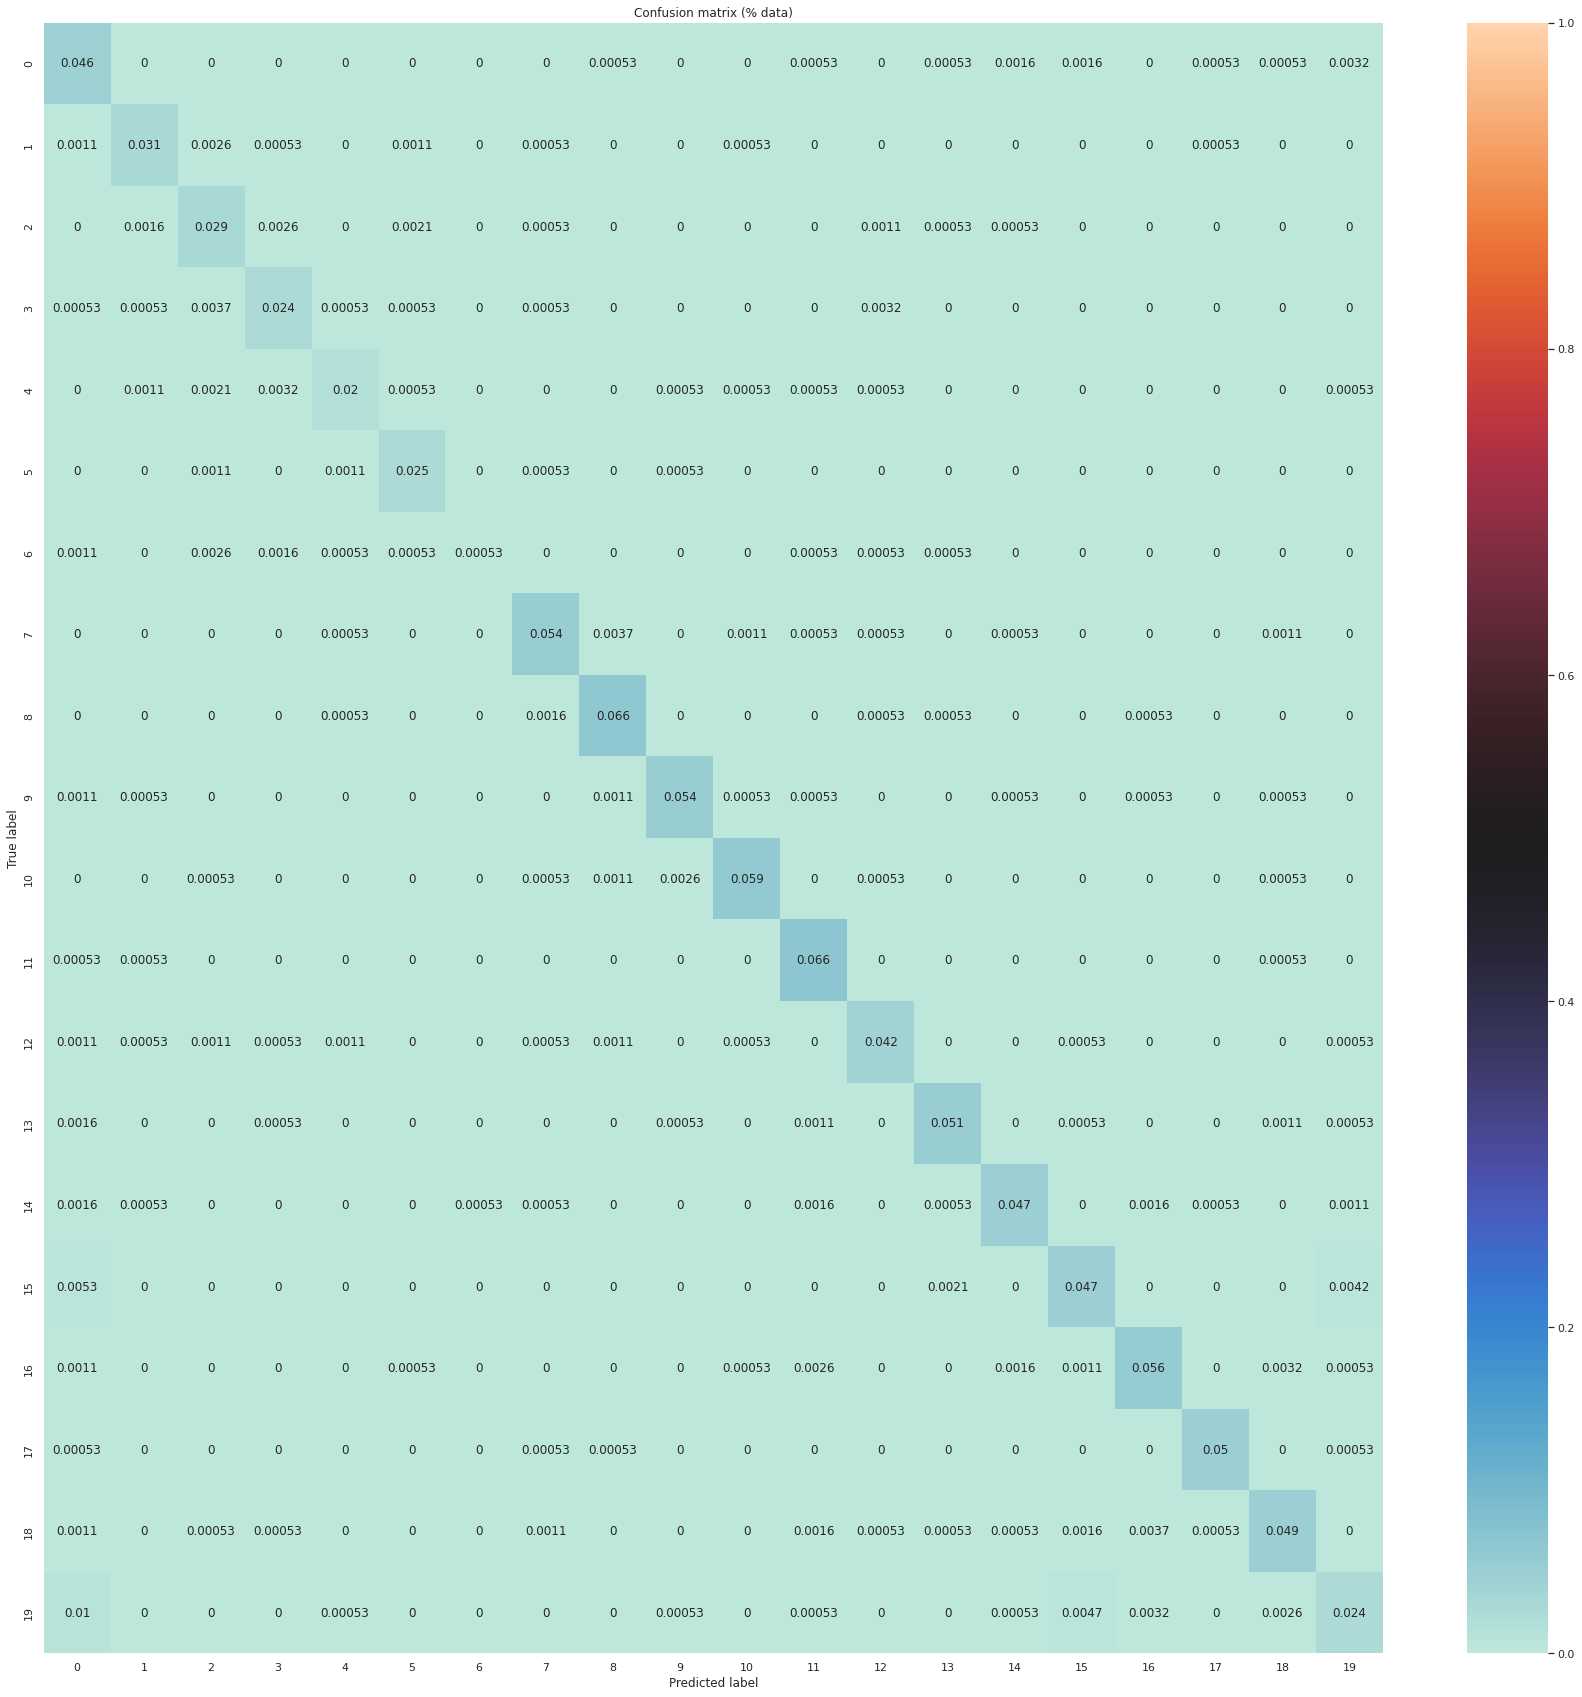

In [38]:
print_metrics(test_y, pred_y)

## Conclusion

There is evidence we can exploit the correlation between the document and the category. Nice result for a quick & dirty baseline.

## References

* [1] [NLTK DOC - Modules](https://www.nltk.org/py-modindex.html)
* [2] [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [3] [nltk.stem.snowball module](https://www.nltk.org/api/nltk.stem.html#module-nltk.stem.snowball)
* [4] [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)